In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv(r"watering_dataset.csv")
df.sample(5)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   soil_moisture        1500 non-null   float64
 1   temperature          1500 non-null   float64
 2   humidity             1500 non-null   float64
 3   light_hours          1500 non-null   float64
 4   days_since_watering  1500 non-null   int64  
 5   plant_type           1500 non-null   object 
 6   label                1500 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 82.2+ KB


,soil_moisture,temperature,humidity,light_hours,days_since_watering
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,46.216470,24.815198,49.313091,7.925254,2.259333
std,12.846191,5.666901,17.002395,2.333639,2.121418
min,13.897520,15.053321,20.025637,4.012904,0.000000
25%,39.388863,19.937925,34.806321,5.890632,1.000000
50%,48.031899,24.507057,48.628217,7.808713,2.000000
75%,55.207109,29.608726,63.811172,10.016868,3.000000
max,75.873576,34.999051,79.974711,11.994473,10.000000


In [9]:
df.value_counts("label")

label
Skip              757
Water_Tomorrow    406
Water_Today       337
Name: count, dtype: int64

## NOW LABELS ARE BALANCES AND WORHTY OF USING 
### since the data is fairly distributed after synthesizing the dataset 

In [10]:
df.drop(columns= ['plant_type'], inplace= True)
X = df[['soil_moisture', 'temperature', 'humidity', 'light_hours', 'days_since_watering']]
y = df.label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_encoded = le.fit_transform(y)

df = pd.concat([X, pd.DataFrame({'label': y_encoded})], axis = 1)
df.sample()

,soil_moisture,temperature,humidity,light_hours,days_since_watering,label
807,22.185037,21.558237,37.313504,4.621331,8,2


<Axes: >

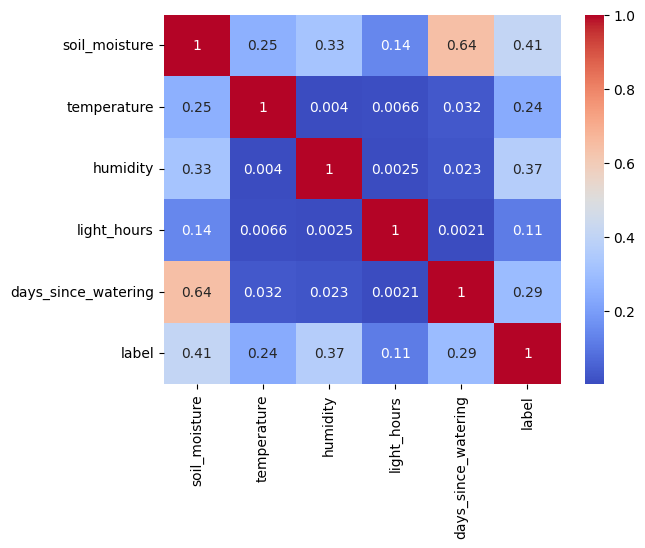

In [11]:
sns.heatmap(abs(df.corr()) , cmap = 'coolwarm', annot= True)

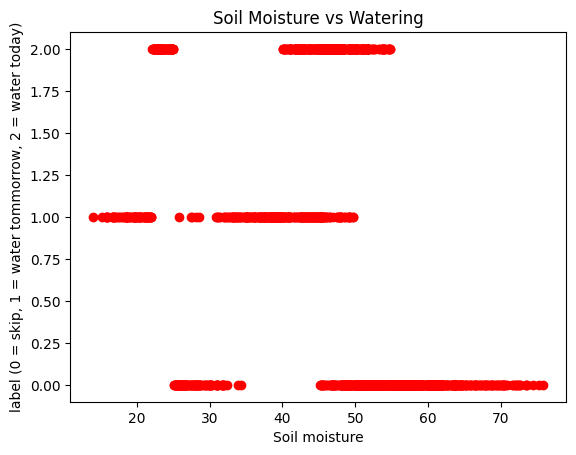

In [12]:
plt.scatter(X.soil_moisture, y_encoded, color = 'red')
plt.xlabel("Soil moisture")
plt.ylabel("label (0 = skip, 1 = water tommorrow, 2 = water today)")
plt.title("Soil Moisture vs Watering")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify = y)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf = RandomForestClassifier(
    n_estimators=200, 
    random_state= 42
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

          Skip       0.89      0.95      0.92       151
   Water_Today       0.92      0.87      0.89        68
Water_Tomorrow       0.78      0.73      0.75        81

      accuracy                           0.87       300
     macro avg       0.86      0.85      0.86       300
  weighted avg       0.87      0.87      0.87       300



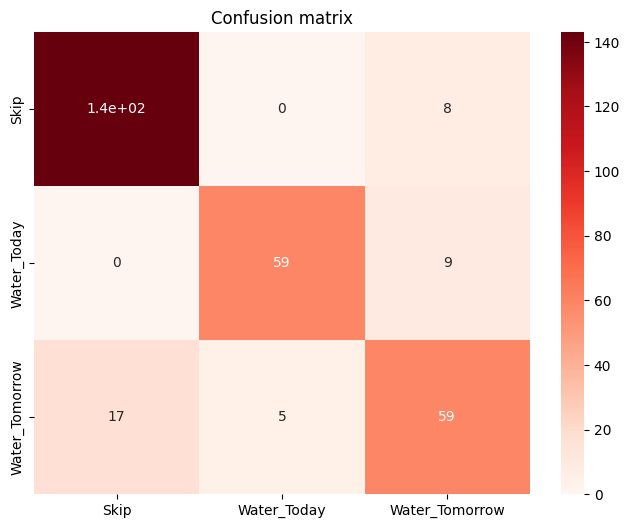

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot= True, cmap = 'Reds', xticklabels= le.classes_, yticklabels= le.classes_)
plt.title("Confusion matrix")
plt.show()

In [16]:
print(accuracy_score(y_test, y_pred))

0.87


In [17]:
## AS WE CAN SEE IT MISCLASIFIES ALOT OF THE WATER TOMORROW 
### yet seems pretty accurate on the skip label which i think is because the skip label is more redundant in the dataset thats why
### the model trained pretty well on it
#### now ill find the best hyperparameters using gridsearch